# UTS - PEMROGRAMAN IOT
## Rico Fadli Alfiansyah - 152023090

# 1. Business Understanding

Performa akademik siswa dipengaruhi oleh beragam faktor seperti latar belakang keluarga, tingkat pendidikan orang tua, dan kondisi lingkungan belajar. Lembaga pendidikan membutuhkan analisis data untuk menemukan pola yang dapat membantu pengambilan keputusan seperti identifikasi awal siswa berisiko rendah performanya serta perencanaan strategi pembelajaran.

Tujuan proyek ini adalah mengklasifikasikan performa akademik siswa menjadi tiga kategori:
- Low  
- Medium  
- High  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


## 2. Data Understanding

Load Dataset

In [2]:
df = pd.read_csv("StudentsPerformance.csv")
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Informasi Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Deskripsi statistik dataset

In [4]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Cek missing value

In [5]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Distribusi (High/Medium/Low)

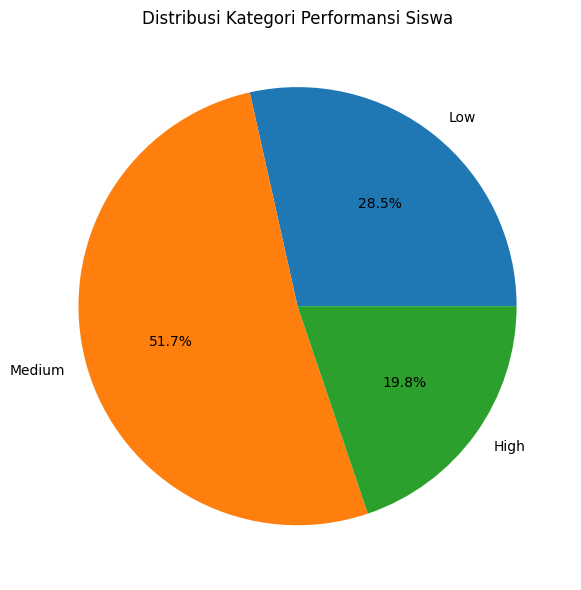

In [8]:
# ===============================================================
# Membuat Kategori Performance
# ===============================================================
df['avg_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

df['Performance'] = pd.cut(
    df['avg_score'],
    bins=[-1, 59.999, 79.999, 1000],
    labels=['Low', 'Medium', 'High']
)

# Hitung jumlah setiap kategori
counts = df['Performance'].value_counts().sort_index()

# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(counts.values, labels=counts.index.astype(str), autopct='%1.1f%%')
plt.title("Distribusi Kategori Performansi Siswa")
plt.tight_layout()
plt.show()


## 3. Data Preparation

In [9]:
# ===============================================================
# Memisahkan fitur & label
# ===============================================================
X = df.drop(columns=['Performance', 'math score', 'reading score', 'writing score', 'avg_score'])
y = df['Performance'].astype(str)

# Memisahkan tipe data
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Encode label
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)


## 4. Modeling

In [10]:
# ===============================================================
# Membandingkan 7 Model
# ===============================================================
models = {
    'LogisticRegression': Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))]),
    'RandomForest': Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
    'KNN': Pipeline([('pre', preprocessor), ('clf', KNeighborsClassifier(n_neighbors=5))]),
    'DecisionTree': Pipeline([('pre', preprocessor), ('clf', DecisionTreeClassifier(random_state=42))]),
    'SVM': Pipeline([('pre', preprocessor), ('clf', SVC(kernel='rbf', probability=True))]),
    'NaiveBayes': Pipeline([('pre', preprocessor), ('clf', GaussianNB())]),
    'GradientBoosting': Pipeline([('pre', preprocessor), ('clf', GradientBoostingClassifier(random_state=42))]),
}

results = []
best_name, best_model, best_f1 = None, None, -1

for name, model in models.items():
    model.fit(X_train, y_train)
    yp = model.predict(X_test)
    acc = accuracy_score(y_test, yp)
    f1 = f1_score(y_test, yp, average='macro')

    results.append({'Model': name, 'Accuracy': acc, 'F1_macro': f1})

    if f1 > best_f1:
        best_f1 = f1
        best_name = name
        best_model = model

df_results = pd.DataFrame(results)
df_results


,Model,Accuracy,F1_macro
0,LogisticRegression,0.540,0.414115
1,RandomForest,0.470,0.408677
2,KNN,0.425,0.361607
3,DecisionTree,0.455,0.422108
4,SVM,0.530,0.349340
5,NaiveBayes,0.515,0.501124
6,GradientBoosting,0.545,0.445815


Final Model (Naive Bayes)

In [11]:
# ===============================================================
# NAIVE BAYES DETAIL + TUNING
# ===============================================================

# Kolom kategorikal & numerik untuk versi NB final
categorical_cols = [
    "gender", "race/ethnicity", "parental level of education",
    "lunch", "test preparation course"
]

numeric_cols = ["math score", "reading score", "writing score"]

df["total_score"] = df[["math score", "reading score", "writing score"]].sum(axis=1)
df["performance"] = pd.cut(df["total_score"], bins=[0, 180, 240, 300],
                           labels=["Low", "Medium", "High"], include_lowest=True)

X = df[categorical_cols + numeric_cols]
y = df["performance"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing ulang
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])

# Pipeline NB
nb_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", GaussianNB())
])

# Tuning
params = {"clf__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

grid = GridSearchCV(nb_pipe, params, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Accuracy (CV):", grid.best_score_)
print("Best Params:", grid.best_params_)

best_nb = grid.best_estimator_
y_pred = best_nb.predict(X_test)

print("\nFinal Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best Accuracy (CV): 0.925
Best Params: {'clf__var_smoothing': 1e-09}

Final Accuracy: 0.905

Classification Report:
               precision    recall  f1-score   support

        High       0.88      0.92      0.90        39
         Low       0.90      0.92      0.91        59
      Medium       0.92      0.89      0.91       102

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.91      0.91      0.91       200



## 5. Deployment

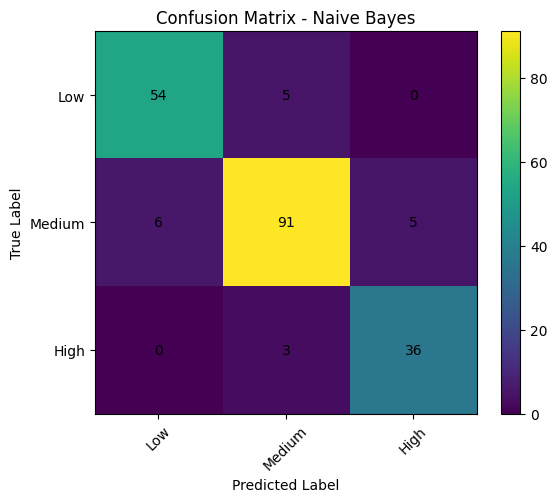

In [13]:
# ===============================================================
# Confusion Matrix
# ===============================================================
cm = confusion_matrix(y_test, y_pred, labels=["Low", "Medium", "High"])

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix - Naive Bayes")
plt.colorbar()

tick_marks = range(3)
plt.xticks(tick_marks, ["Low", "Medium", "High"], rotation=45)
plt.yticks(tick_marks, ["Low", "Medium", "High"])

for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, cm[i][j], ha='center', va='center')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


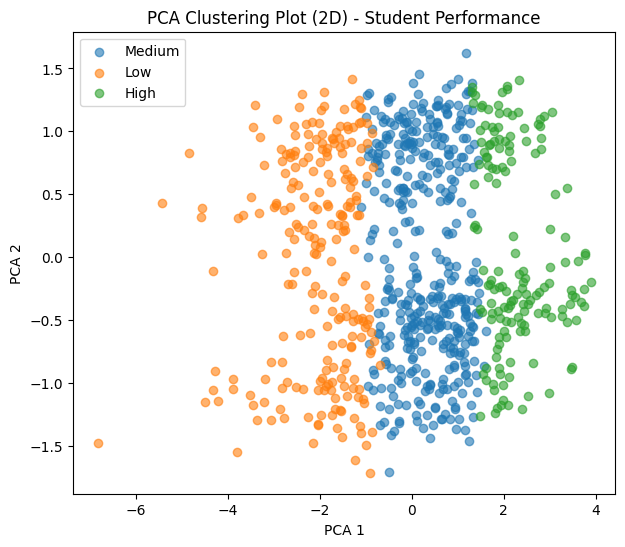

In [14]:
# ===============================================================
# PCA Visualization
# ===============================================================
X_train_transformed = preprocessor.fit_transform(X_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_transformed)

plt.figure(figsize=(7, 6))
for label in y_train.unique():
    idx = (y_train == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.6)

plt.title("PCA Clustering Plot (2D) - Student Performance")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()
